<a href="https://colab.research.google.com/github/ethanelkaim/Deep-Learning-Models/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training of a Fully Connected network on MNIST

In [ ]:
import torch

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def tanh(x):
    return torch.div(torch.exp(x) - torch.exp(-x), torch.exp(x) + torch.exp(-x))


def softmax(x):
    exp_x = torch.exp(x.T - torch.max(x, dim=-1).values).T  # Subtracting max(x) for numerical stability
    return exp_x / exp_x.sum(dim=-1, keepdim=True)

In [ ]:
def d_sigmoid(x):
    sig_x = sigmoid(x)
    return sig_x * (1 - sig_x)


def d_tanh(x):
     return 1 - tanh(x) ** 2


def d_softmax(x):
    s = softmax(x)
    return s * (1 - s)

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Constants
SEED = 42
EPOCHS = 16
BATCH_SIZE = 32
NUM_OF_CLASSES = 10

# Setting seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


# Transformation for the data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torch.flatten])


# Cross-Entropy loss implementation
def one_hot(y, num_of_classes=10):
    hot = torch.zeros((y.size()[0], num_of_classes))
    hot[torch.arange(y.size()[0]), y] = 1
    return hot

def cross_entropy(y, y_hat):
    return -torch.sum(one_hot(y) * torch.log(y_hat)) / y.size()[0]

In [ ]:
# Create dataloaders
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,)

100%|██████████| 9912422/9912422 [00:00<00:00, 107223258.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99454592.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25999005.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2408410.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class FullyConnectedNetwork:
    def __init__(self, input_size, output_size, hidden_size1, activiation_func, lr=0.01):
        # parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size1 = hidden_size1

        # activation function
        self.activation_func = activiation_func

        # weights
        self.W1 = torch.randn(self.input_size, self.hidden_size1)
        self.b1 = torch.zeros(self.hidden_size1)

        self.W2 = torch.randn(self.hidden_size1, self.output_size)
        self.b2 = torch.zeros(self.output_size)

        self.lr = lr


    def backward(self, x, y, y_hat):
        y_one_hot = one_hot(y, num_of_classes=self.output_size)
        error = y_hat - y_one_hot
        dW2 = self.h1.T.matmul(error)
        db2 = error.sum(0)
        sigmoid_prime = self.h1 * (1 - self.h1)
        error_hidden = error.matmul(self.W2.T) * sigmoid_prime
        dW1 = x.T.matmul(error_hidden)
        db1 = error_hidden.sum(0)

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def forward(self, x):
        z1 = torch.matmul(x, self.W1) + self.b1
        self.h1 = self.activation_func(z1)
        z2 = torch.matmul(self.h1, self.W2) + self.b2
        y_hat = softmax(z2)
        return y_hat

In [ ]:
set_seed(SEED)
model = FullyConnectedNetwork(784, 10, 128, sigmoid, lr=0.01)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
def train(model, train_dataloader, test_dataloader, epochs):
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x, y in train_dataloader:
            y_hat = model.forward(x.view(-1, 28*28))
            loss = cross_entropy(y, y_hat)
            model.backward(x.view(-1, 28*28), y, y_hat)
            total_loss += loss.item()
            _, predicted = torch.max(y_hat, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        avg_loss = total_loss / len(train_dataloader.dataset)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        test_loss, test_accuracy = test(model, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
def test(model, dataloader):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = model.forward(x.view(-1, 28*28))
            loss = cross_entropy(y, y_hat)
            total_loss += loss.item()
            _, predicted = torch.max(y_hat, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

In [ ]:
train(model, train_dataloader, test_dataloader, EPOCHS)

Epoch 1, Train Loss: 0.0218, Train Accuracy: 0.8227, Test Loss: 0.0120, Test Accuracy: 0.8854
Epoch 2, Train Loss: 0.0097, Train Accuracy: 0.9091, Test Loss: 0.0094, Test Accuracy: 0.9082
Epoch 3, Train Loss: 0.0077, Train Accuracy: 0.9280, Test Loss: 0.0083, Test Accuracy: 0.9201
Epoch 4, Train Loss: 0.0065, Train Accuracy: 0.9391, Test Loss: 0.0076, Test Accuracy: 0.9256
Epoch 5, Train Loss: 0.0058, Train Accuracy: 0.9459, Test Loss: 0.0071, Test Accuracy: 0.9307
Epoch 6, Train Loss: 0.0052, Train Accuracy: 0.9522, Test Loss: 0.0067, Test Accuracy: 0.9347
Epoch 7, Train Loss: 0.0047, Train Accuracy: 0.9567, Test Loss: 0.0064, Test Accuracy: 0.9378
Epoch 8, Train Loss: 0.0043, Train Accuracy: 0.9609, Test Loss: 0.0062, Test Accuracy: 0.9404
Epoch 9, Train Loss: 0.0040, Train Accuracy: 0.9638, Test Loss: 0.0060, Test Accuracy: 0.9420
Epoch 10, Train Loss: 0.0037, Train Accuracy: 0.9667, Test Loss: 0.0059, Test Accuracy: 0.9421
Epoch 11, Train Loss: 0.0034, Train Accuracy: 0.9691, Test 

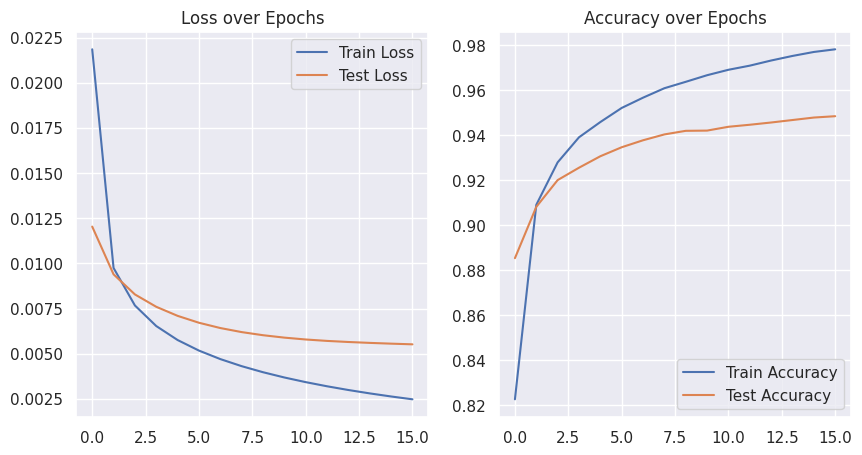

In [ ]:
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
students_ids = "931202543_932191265"
torch.save({"W1": model.W1, "W2": model.W2, "b1": model.b1, "b2": model.b2}, f"HW1_{students_ids}.pkl")

<p style="font-size: 17px"> b) Training the model with various learning rates (3).
<ul style="font-size: 17px">
<li> Plot of the model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li>Discussion of the differences in training with different learning rates.

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
all_train_losses = []
all_test_losses = []
all_train_accuracies = []
all_test_accuracies = []

In [ ]:
for lr in learning_rates:
    model = FullyConnectedNetwork(784, 10, 128, sigmoid, lr=lr)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f'Training with learning rate: {lr}')
    train(model, train_dataloader, test_dataloader, EPOCHS)

    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)

Training with learning rate: 0.001
Epoch 1, Train Loss: 0.0588, Train Accuracy: 0.5860, Test Loss: 0.0279, Test Accuracy: 0.7568
Epoch 2, Train Loss: 0.0237, Train Accuracy: 0.7880, Test Loss: 0.0199, Test Accuracy: 0.8195
Epoch 3, Train Loss: 0.0185, Train Accuracy: 0.8307, Test Loss: 0.0168, Test Accuracy: 0.8473
Epoch 4, Train Loss: 0.0160, Train Accuracy: 0.8530, Test Loss: 0.0150, Test Accuracy: 0.8631
Epoch 5, Train Loss: 0.0143, Train Accuracy: 0.8668, Test Loss: 0.0138, Test Accuracy: 0.8723
Epoch 6, Train Loss: 0.0132, Train Accuracy: 0.8765, Test Loss: 0.0129, Test Accuracy: 0.8797
Epoch 7, Train Loss: 0.0123, Train Accuracy: 0.8839, Test Loss: 0.0123, Test Accuracy: 0.8833
Epoch 8, Train Loss: 0.0116, Train Accuracy: 0.8909, Test Loss: 0.0117, Test Accuracy: 0.8873
Epoch 9, Train Loss: 0.0110, Train Accuracy: 0.8962, Test Loss: 0.0113, Test Accuracy: 0.8913
Epoch 10, Train Loss: 0.0105, Train Accuracy: 0.9003, Test Loss: 0.0109, Test Accuracy: 0.8954
Epoch 11, Train Loss: 0.

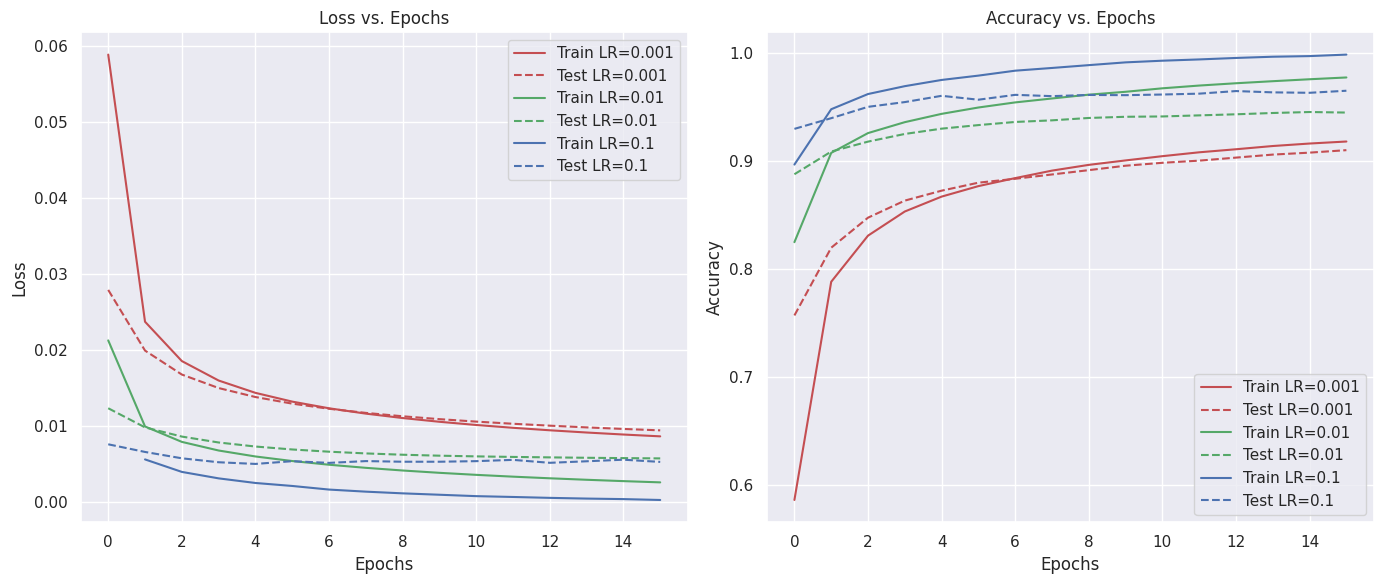

In [ ]:
colors = ['r', 'g', 'b']
plt.figure(figsize=(14, 6))

for i, lr in enumerate(learning_rates):
    plt.subplot(1, 2, 1)
    plt.plot(all_train_losses[i], color=colors[i], label=f'Train LR={lr}')
    plt.plot(all_test_losses[i], '--', color=colors[i], label=f'Test LR={lr}')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_train_accuracies[i], color=colors[i], label=f'Train LR={lr}')
    plt.plot(all_test_accuracies[i], '--', color=colors[i], label=f'Test LR={lr}')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

-Low Learning Rate (0.001): With a low learning rate, the model is expected to converge slowly. This can be seen in a gradual decrease in loss and a slow improvement in accuracy. The model might not reach its full potential within the given epochs if the learning rate is too low.

-Medium Learning Rate (0.01): This is often a good starting point for many models and can lead to a balance between convergence speed and stability.

-High Learning Rate (0.1): With a high learning rate, the model might show rapid initial improvement, but it could also overshoot the minimum, leading to potentially erratic behavior or divergence in loss.
By comparing these plots, you can observe the trade-offs in choosing a learning rate: too low might be too slow, too high can be unstable, and a medium rate might offer a balance. However, the optimal learning rate can vary depending on the specific architecture and data, and sometimes more sophisticated learning rate schedules are used, where the learning rate changes over time.

## Implementation and training of a CNN

<ul style="font-size: 17px">
<li>Training of the model and plot the model's accuracy and loss (both on train and validation sets) as a function of the epochs. </li>
<li>Report of the test set accuracy.</li>
<li>Discussion of the progress you made and describe your final model.</li>

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


# Hyper Parameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [ ]:
from google.colab import drive
# Mount Google Drive
#All the birds/dogs files are dowloaded and accessed via my drive
drive.mount('/content/drive')


l1_lambda = 0.002

# Load Dataset


transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2434, 0.2615)),
])


train_dataset = ImageFolder(root='/content/drive/My Drive/train', transform=transform)
test_dataset = ImageFolder(root='/content/drive/My Drive/test', transform=transform)
val_dataset = ImageFolder(root='/content/drive/My Drive/val', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Première couche de convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)  # padding=2 pour conserver la taille
        # Couche de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Deuxième couche de convolution
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)  # Pas de padding, réduction de taille

        # Couches linéaires (fully connected)
        # La taille des caractéristiques doit être ajustée en fonction de la sortie de la dernière couche de pooling
        self.fc1 = nn.Linear(16 * 8 * 8, 90)  # Ajustez 16*10*10 en fonction de la sortie de conv2+pooling
        self.fc2 = nn.Linear(90, 43)


    def forward(self, x):
        # Appliquer conv1 -> activation -> pooling
        x = self.pool(torch.relu(self.conv1(x)))
        # Appliquer conv2 -> activation -> pooling
        x = self.pool(torch.relu(self.conv2(x)))
        # Aplatir les caractéristiques pour les couches fully connected
        x = x.view(-1, 16 * 8 * 8)  # Ajustez cette dimension
        # Passer à travers les couches fully connected avec des activations relu
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Couche de sortie

        return x

In [ ]:
import torch.optim as optim

model = SimpleCNN()


nombre_total_parametres = sum(p.numel() for p in model.parameters() if p.requires_grad)



if torch.cuda.is_available():
  model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # L1 regularization
        l1_reg = torch.tensor(0., device=images.device)
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        loss += l1_lambda * l1_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss)
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val=0

    with torch.no_grad():
        for images, labels in val_loader:
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_accuracy.append(100 * correct_val / total_val)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], 'f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, 'f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%')


Epoch [1/20], Train Loss: 2.5732, Train Accuracy: 60.98%, Val Loss: 0.9861, Val Accuracy: 59.46%
Epoch [2/20], Train Loss: 1.2429, Train Accuracy: 69.09%, Val Loss: 0.9502, Val Accuracy: 58.45%
Epoch [3/20], Train Loss: 1.0614, Train Accuracy: 71.25%, Val Loss: 0.9072, Val Accuracy: 60.14%
Epoch [4/20], Train Loss: 0.9966, Train Accuracy: 72.23%, Val Loss: 0.9412, Val Accuracy: 61.15%
Epoch [5/20], Train Loss: 0.9395, Train Accuracy: 72.12%, Val Loss: 0.9274, Val Accuracy: 59.46%
Epoch [6/20], Train Loss: 0.8740, Train Accuracy: 73.33%, Val Loss: 1.0590, Val Accuracy: 55.74%
Epoch [7/20], Train Loss: 0.8584, Train Accuracy: 73.56%, Val Loss: 1.0795, Val Accuracy: 60.47%
Epoch [8/20], Train Loss: 0.8499, Train Accuracy: 72.84%, Val Loss: 0.8986, Val Accuracy: 62.84%
Epoch [9/20], Train Loss: 0.8091, Train Accuracy: 74.39%, Val Loss: 0.8412, Val Accuracy: 64.19%
Epoch [10/20], Train Loss: 0.7921, Train Accuracy: 74.17%, Val Loss: 0.9694, Val Accuracy: 62.16%
Epoch [11/20], Train Loss: 0.

In [ ]:
model.eval()
with torch.no_grad():
    good = 0
    total = 0
    for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      good += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * good / total:.2f}%')

Test Accuracy: 77.55%


In [ ]:
print(f'Numbers of params of our model: {nombre_total_parametres}')

Numbers of params of our model: 99035


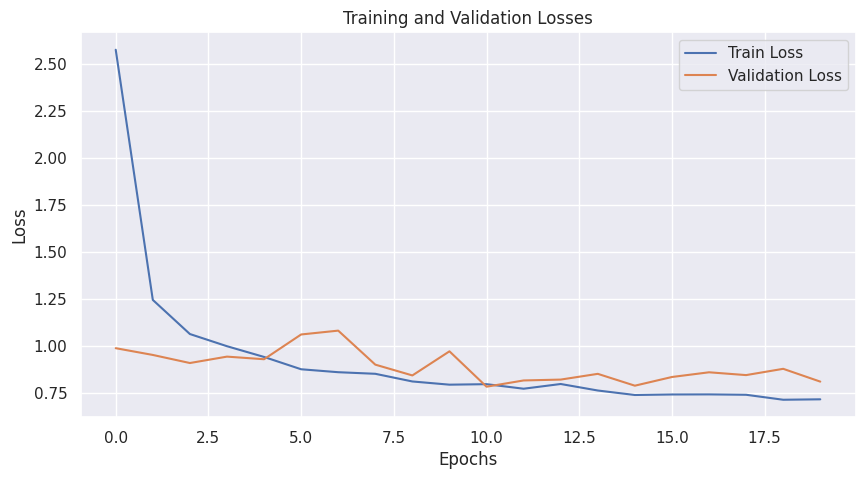

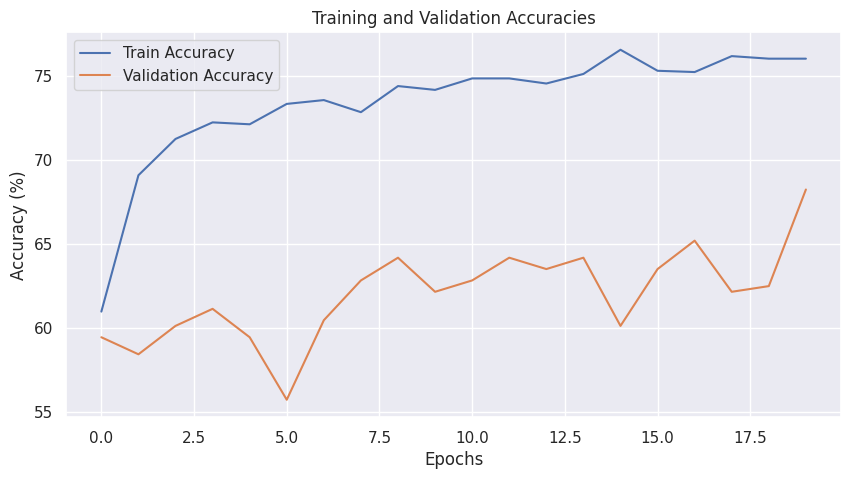

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()
# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()



We modified the architecture of a SimpleCNN (convolutional) designed for processing 40x40 images to reduce its parameter count while aiming to maintain or improve its performance. The original network consisted of two convolutional layers followed by max pooling, and two fully connected layers for classification.

What We Did:
Adjusted Convolutional Layers: We retained the first convolutional layer (conv1) with padding=2 to preserve the spatial size of the input, and a second convolutional layer (conv2) without padding to reduce the spatial dimension.

Pooling Layer: We applied max pooling after each convolution to reduce the spatial dimensions by half, decreasing the overall number of features to be processed by subsequent layers.

Fully Connected Layers: We recalculated the input size for the first fully connected layer (fc1) based on the output size from the final pooling layer. We optimized the number of neurons in fc1 to 93, reducing the number of parameters further. The network finishes with a second fully connected layer (fc2) that maps to 10 output classes.

Streamlined Forward Pass: In the forward method, we ensured that the tensor dimensions were correctly adjusted before entering the fully connected layers by flattening the output of the last pooling layer.

Why We Did It:
Reduce Parameters: To make the network more efficient and reduce the risk of overfitting by decreasing the number of trainable parameters.
Maintain Performance: By carefully adjusting layer parameters and sizes, we aimed to preserve the network's ability to extract meaningful features from the input images for accurate classification.
Efficiency and Simplicity: A model with fewer parameters is not only faster to train but also requires less memory, making it more suitable for deployment in resource-constrained environments.
This approach demonstrates how adjusting convolutional and pooling layer parameters, along with thoughtful design of fully connected layers, can lead to a more parameter-efficient CNN architecture.
Our numbers of parameters is 99035
We use the convolutional layers like we saw in course with a kernel of 5 sometimes with and sometimes without padding

We could see that our reults are good because our train accuracy go up and we found a result of more thant 75% !



## Analyzing of a Pre-trained CNN

In this part, you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

<code>normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])</code>
<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>


1. Load a pre-trained VGG16 with PyTorch using torchvision.models.vgg16(pretrained=True, progress=True, **kwargs) (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (<code>model.eval()</code>).

2. Load the images in the 'birds' folder and display them.

3. Pre-process the images to fit VGG16's architecture. What steps did you take?

4. Feed the images (forward pass) to the model. What are the outputs?

5. Choose an image of a dog in the 'dogs' folder, display it and feed it to network. What are the outputs?

6. For the first 3 filters in the first layer of VGG16, plot the filters, and then plot their response (their output). Explain your observations.

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]


In [ ]:
def load_and_preprocess_images(folder):
  images = []
  for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    images.append((img, img_tensor))
  return images


In [ ]:
birds_folder = '/content/drive/My Drive/birds'
bird_images = load_and_preprocess_images(birds_folder)


The preprocess step readies the image for the neural network. It resizes the image for consistency, crops to highlight key parts, converts it to a tensor for network processing, and normalizes pixel values for stable input.

Bird 1 Output:
tensor([[ 2.7060e+00,  5.0277e+00,  2.9450e+00, -2.4858e-02,  2.4988e+00,
          5.6518e+00, -3.4072e-01,  3.1121e+00,  1.6135e+00,  2.4929e+00,
          9.1234e+00,  6.1760e+00,  7.7521e+00,  6.6037e+00,  1.1655e+01,
          7.8751e+00,  1.3027e+01,  1.2279e+01,  1.1689e+01,  1.0140e+01,
          1.5392e+01,  1.3191e+01,  1.8790e+00,  5.6937e+00,  4.0444e+00,
          6.2261e-01,  4.5118e+00, -2.2118e-01, -1.2594e+00,  3.5354e+00,
          3.3018e+00,  2.1493e+00,  3.5794e+00,  2.7929e+00,  4.5813e+00,
          1.6225e+00,  5.0983e+00, -2.6581e+00,  5.2292e+00,  1.2032e+00,
          1.0537e+01,  6.8741e+00,  1.1330e+01,  8.1567e+00,  6.2877e+00,
         -1.1993e+00,  9.1111e+00,  1.1892e+01, -2.2449e-01, -8.4637e-01,
         -6.9902e-01,  4.0637e+00,  3.5153e+00,  5.4052e+00,  7.5434e-01,
          4.2801e+00, -5.1978e-01, -1.6011e+00,  3.9177e+00,  1.2785e+01,
          3.0190e+00, -1.9027e+00,  8.6624e-01,  6.0651e+00,  8.1334e+00,
          5.0426e+00,  

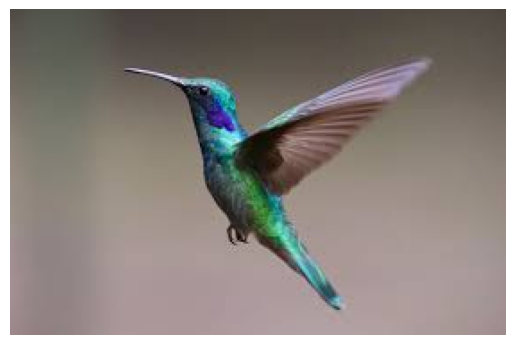

Bird 2 Output:
tensor([[ 1.4935e+00,  8.1809e+00, -1.5602e+00, -3.8882e+00, -4.1595e+00,
         -1.2790e+00, -2.9763e+00,  7.4214e+00,  6.3584e+00, -4.3470e-02,
          9.5735e+00,  1.3498e+01,  9.7240e+00,  5.7353e+00,  1.0312e+01,
          8.6859e+00,  1.2129e+01,  7.4136e+00,  7.8780e+00,  5.0433e+00,
          6.7286e+00,  8.6189e+00,  5.1014e+00,  6.9557e+00,  2.1671e+00,
          3.2122e+00,  2.7483e+00,  4.0267e+00, -1.8364e-01,  2.1162e+00,
         -4.7759e-01,  6.0199e+00,  3.4347e+00, -2.1924e+00, -2.1848e+00,
          9.3483e-01,  2.7815e+00,  2.2177e+00,  2.5251e+00,  3.2634e+00,
          7.4696e+00,  2.9861e+00,  8.1169e+00,  3.6356e+00,  1.7902e+00,
          3.2610e-01,  7.4471e+00,  5.6811e+00,  3.9690e-01, -7.6875e-01,
         -1.3764e+00, -3.8673e-01,  4.2682e-01,  2.2279e+00, -2.1433e+00,
          3.0128e+00, -1.5366e-01, -1.0404e+00, -3.3834e-01,  5.4065e+00,
          6.6944e-01, -2.3057e+00, -7.1167e-01,  7.8787e-01,  4.7581e+00,
         -8.2578e-01, -

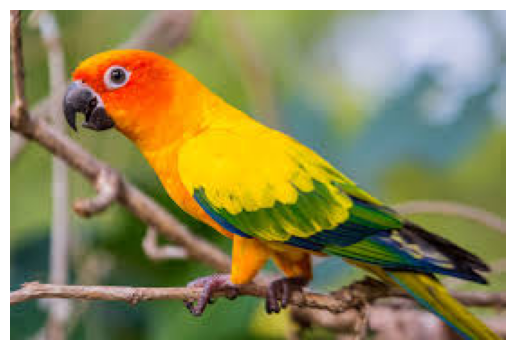

In [ ]:
for i, (img, img_tensor) in enumerate(bird_images):
  with torch.no_grad():
    output = vgg16(img_tensor)
    print(f'Bird {i+1} Output:')
    plt.imshow(img)
    print(output)

    plt.axis('off')
    plt.show()


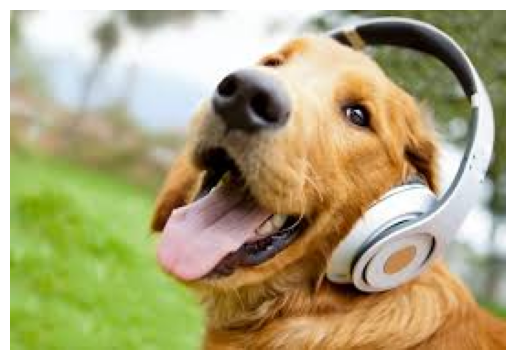

Dog Output:
tensor([[-9.3060e-01, -1.5955e+00, -2.9181e+00, -4.1349e+00, -2.8313e+00,
         -2.4859e+00, -3.1912e+00, -2.7256e+00, -1.1700e+00, -2.7315e+00,
         -2.8770e+00, -1.5801e+00, -4.0232e+00, -4.2405e+00, -2.6859e+00,
         -2.8089e+00, -3.9026e+00, -2.3800e+00, -2.5218e+00, -3.2893e+00,
         -2.9577e+00, -1.5593e+00, -2.3144e+00, -2.4575e+00, -3.1204e+00,
         -1.3885e+00, -1.6896e+00, -6.0798e-01, -1.2195e+00, -1.8533e+00,
         -2.4155e+00, -7.8195e-01, -5.7745e-01, -2.2821e+00, -2.4605e+00,
         -3.5580e+00, -1.9797e+00, -2.1328e+00, -3.2781e+00, -4.5888e+00,
         -3.6562e+00, -4.3453e+00, -2.5557e+00, -2.4689e+00, -4.7558e+00,
         -3.4266e+00, -4.4510e+00, -2.2288e+00, -3.7720e+00, -5.1290e+00,
         -4.6302e+00, -8.4347e-01, -7.2791e-01, -1.0448e+00, -3.1612e+00,
         -2.6060e+00, -3.5917e+00, -3.3642e+00, -3.0165e+00, -1.0052e+00,
         -1.7103e+00, -1.3729e+00, -8.7586e-01,  4.4460e-01, -8.2738e-01,
          3.1336e-02, -1.8

In [ ]:
dogs_folder = '/content/drive/My Drive/dogs'
dog_files = os.listdir(dogs_folder)
dog_img_path = os.path.join(dogs_folder, dog_files[2])
dog_img = Image.open(dog_img_path)
plt.imshow(dog_img)
plt.axis('off')
plt.show()
dog_tensor = preprocess(dog_img).unsqueeze(0)
# Feed the dog image to the model
with torch.no_grad():
    dog_output = vgg16(dog_tensor)
print("Dog Output:")
print(dog_output)

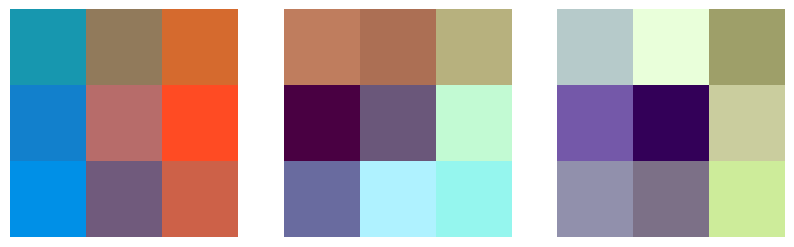

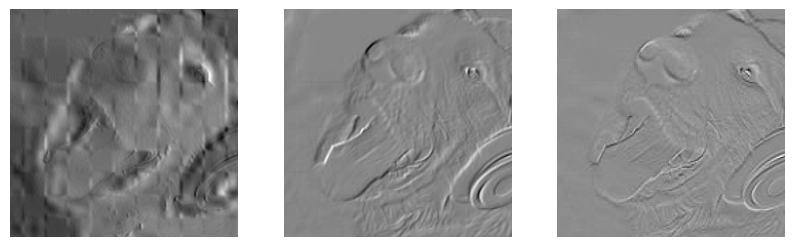

In [ ]:
filters = vgg16.features[0].weight.data.clone()
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
  filter_img = filters[i].clone().detach().cpu()
  filter_img = filter_img - filter_img.min()
  filter_img /= filter_img.max()
  axes[i].imshow(filter_img.permute(1, 2, 0))
  axes[i].axis('off')
plt.show()
# Plot the response of the first 3 filters for the choosen dog image
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
  response = torch.nn.functional.conv2d(dog_tensor, filters[i].unsqueeze(0))
  axes[i].imshow(response.squeeze().numpy(), cmap='gray')
  axes[i].axis('off')
plt.show()


The code snippet demonstrates how to process and analyze an image using a convolutional neural network (CNN), specifically using the VGG16 model. It involves loading an image of a dog from a specified directory, displaying it, and then processing it to feed into the model. The focus here is on examining the model's first layer by observing the activation of its filters in response to the image. Brighter areas in the output indicate stronger activations, which helps in understanding the types of patterns or features (like edges, textures, or shapes) the network's first layer is detecting and learning from the image. This analysis provides insights into the initial stages of how the neural network processes and interprets visual information.